# OpenET SSEBop
## Collection "Overpass" Examples

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.ssebop as model

ee.Initialize()

In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

image_size = 768
landsat_cs = 30

### Input parameters

In [3]:
collections = ['LANDSAT/LC08/C02/T1_L2','LANDSAT/LE07/C02/T1_L2']
# collections = ['LANDSAT/LC08/C02/T1_L2']

et_reference_source = 'projects/openet/reference_et/cimis/daily'
et_reference_band = 'etr_asce'
et_reference_factor = 1.0
et_reference_resample = 'nearest'
et_reference_date_type = 'daily'
# et_reference_source = 'projects/openet/reference_et/gridmet/daily'
# et_reference_band = 'etr'
# et_reference_factor = 1.0
# et_reference_resample = 'nearest'
# et_reference_date_type = 'daily'

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2018-07-01'
end_date = '2018-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

test_point = ee.Geometry.Point(-121.5265, 38.7399)
study_area = ee.Geometry.Rectangle(-122.00, 38.60, -121.00, 39.0)

# Hard code the study area and CRS
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
study_crs = 'EPSG:32610'

### Landsat 7 & 8 Collection 2 Image Collection

In [4]:
model_obj = model.Collection(
    collections=collections,
    et_reference_source=et_reference_source, 
    et_reference_band=et_reference_band,
    et_reference_factor=et_reference_factor,
    et_reference_resample=et_reference_resample,
    et_reference_date_type=et_reference_date_type,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    # filter_args={},
)
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C02/T1_L2/LC08_044033_20180703',
 'LANDSAT/LC08/C02/T1_L2/LC08_044033_20180719',
 'LANDSAT/LE07/C02/T1_L2/LE07_044033_20180711',
 'LANDSAT/LE07/C02/T1_L2/LE07_044033_20180727']


In [5]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict).sort_index()

## "Overpass" Collection

In [6]:
overpass_coll = model_obj.overpass(variables=['ndvi', 'et', 'et_reference', 'et_fraction'])

In [7]:
overpass_df = get_region_df(overpass_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(overpass_df)
print('')
pprint.pprint(overpass_df[['et', 'et_reference']].sum())

                ndvi        et  et_reference  et_fraction
2018-07-03  0.719342  7.030925      8.388551     0.838157
2018-07-11  0.769542  8.122280      9.242724     0.878776
2018-07-19  0.867405  9.787650     10.390136     0.942014
2018-07-27  0.888550  8.878077      9.474789     0.937021

et              33.818932
et_reference    37.496200
dtype: float64


### NDVI

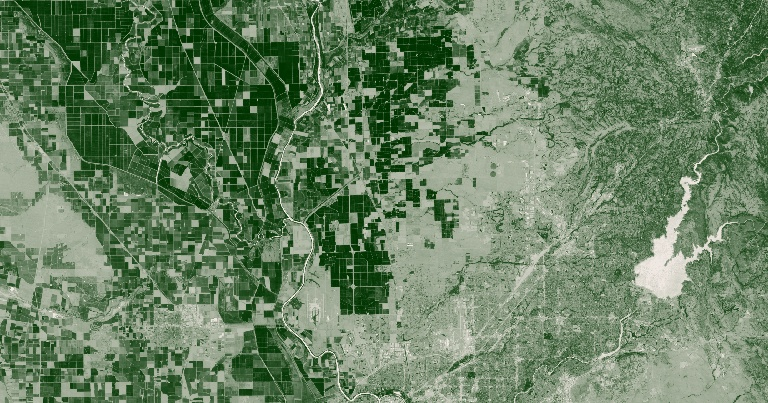

In [8]:
image_url = ee.Image(overpass_coll.select(['ndvi']).mean())\
    .reproject(crs=study_crs, scale=30)\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ','.join(ndvi_palette), 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET fraction

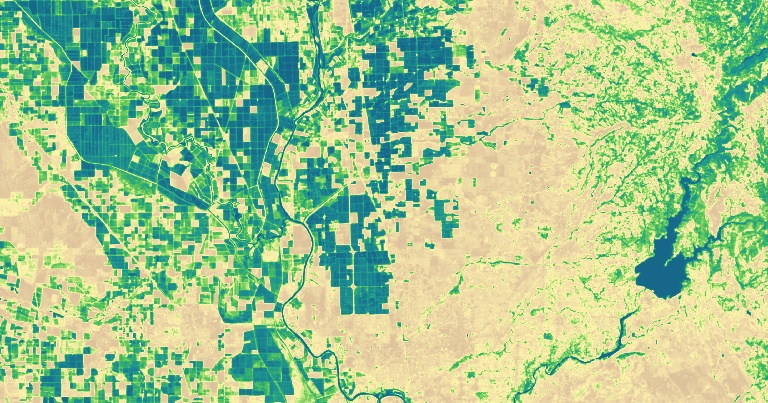

In [9]:
image_url = ee.Image(overpass_coll.select(['et_fraction']).mean())\
    .reproject(crs=study_crs, scale=30)\
    .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': ','.join(et_palette), 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Reference ET

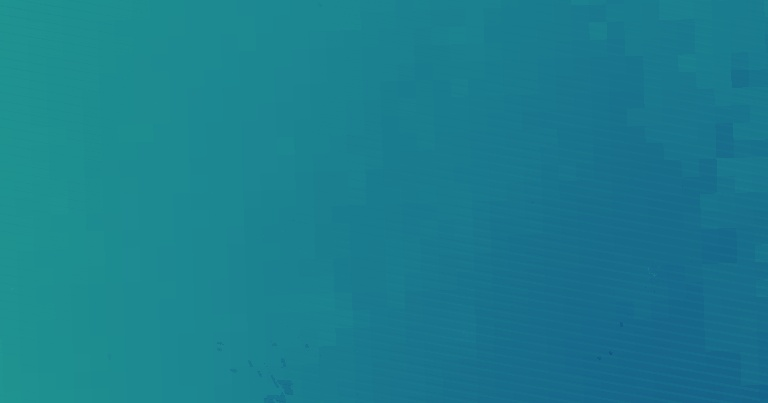

In [10]:
image_url = ee.Image(overpass_coll.select(['et_reference']).mean())\
    .reproject(crs=study_crs, scale=30)\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': ','.join(et_palette), 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET

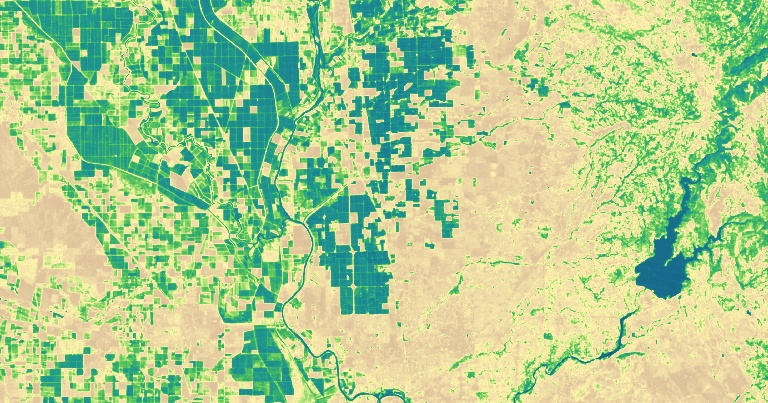

In [11]:
image_url = ee.Image(overpass_coll.select(['et']).mean())\
    .reproject(crs=study_crs, scale=30)\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': ','.join(et_palette), 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')